In [207]:
import time
import torch

import monai
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset, PersistentDataset, SmartCacheDataset
from monai.apps import DecathlonDataset
from monai.transforms import (
    MapTransform,
)

print_config()

MONAI version: 0.8.1
Numpy version: 1.19.5
Pytorch version: 1.10.1+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.13.1
Pillow version: 8.4.0
Tensorboard version: 2.10.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.2+cu102
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.4.5
pandas version: 0.23.0
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [210]:

# Parent directory where "train" and "test" folders are located
parent_directory = '//mnt/c/Users/ahmad/OneDrive - Delft University of Technology/studi/TUD/Internship/Clean_data/'

# Function to extract label from the folder path
def extract_label(folder_path):
    # Split the folder path and take the last two elements as the label
    components = folder_path.split(os.path.sep)
    label = os.path.join(components[-1])
    return label

# Create a list of dictionaries with keys "path" and "label"
train_list = []
test_list = []

# Iterate through "train" and "test" folders

for split in ["Train Sample", "Test Sample"]:
    split_folder = os.path.join(parent_directory, split)
    # Iterate through DICOM folders within the split folder
    if split == "Train Sample":
        for root, _, files in os.walk(split_folder):
            for file in files:
                if file.lower().endswith('.dcm'):
                    dicom_file_path = os.path.join(root, file)
                    label = extract_label(root)
                    train_list.append({"path": dicom_file_path, "label": label})
    else:
        for root, _, files in os.walk(split_folder):
            for file in files:
                if file.lower().endswith('.dcm'):
                    dicom_file_path = os.path.join(root, file)
                    label = extract_label(root)
                    test_list.append({"path": dicom_file_path, "label": label})
        


# Define a custom Dataset class to load DICOM files and extract data
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__(data, transform)

    def __getitem__(self, index):
        dicom_file_path = self.data[index]["path"]
        label = self.data[index]["label"]

        # Load the DICOM file and extract information
        dicom_data = pydicom.dcmread(dicom_file_path)
        
        #take image data
        pixel_data = dicom_data.pixel_array
        # DICOM header attributes
        patient_ID = dicom_data.PatientName
        if hasattr(dicom_data, 'RepetitionTime'):
            repetition_time = int(float(dicom_data.RepetitionTime))
            #print(f"Repetition Time (TR): {repetition_time}")
            
        if hasattr(dicom_data, 'EchoTime'):
            echo_time = int(float(dicom_data.EchoTime))
            #print(f"Echo Time (TE): {echo_time}")
        
        if hasattr(dicom_data, 'MagneticFieldStrength'):
            magnetic_strength = dicom_data.MagneticFieldStrength
            #print(f"Magnetic Field Strength: {round(magnetic_strength, 1)}")
        return {"image": pixel_data, "label": label, "patient_name": patient_ID, "metadata": {"repetition_time": repetition_time, "echo_time": echo_time, "magnetic_strength": magnetic_strength}}

# Create a MONAI dataset
train = CustomDataset(data=train_list)
test = CustomDataset(data=test_list)



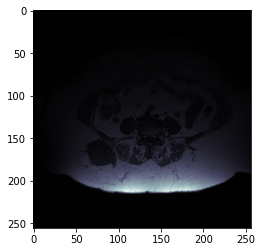

In [225]:
plt.imshow(train[0]['image'], plt.cm.bone)

In [220]:
train_dataset = monai.data.Dataset(train, transform=None)

print(f"Length of dataset is {len(train_dataset)}")


Length of dataset is 1409


In [39]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

In [40]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

NameError: name 'val_files' is not defined